## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR 

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

In [1]:
#Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import requests
from datetime import datetime, timedelta

# Configuración de estilo visual
sns.set_style("whitegrid") #para lineas con cuadriculas grises y fondo blanco
plt.rcParams['figure.figsize'] = (10, 6) #definimos el tamaño de los graficos

1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [2]:
# Construir URL API BCRP
# Códigos: Interbancario (PD04637PD), SBS (PD04639PD), Oro (PD04704XD), Cobre (PD04701XD)
base_url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api" #servidor de datos del BCRP
codigos = "PD04637PD-PD04639PD-PD04704XD-PD04701XD" #se separan por guiones porque asi lo exige el bcrp
#ejemplo que ponen: https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PN01288PM-PN01289PM-PN01290PM-PN01291PM
fmt = "json"
start_date = "2020-01-01"
end_date = "2023-12-31" #tomamos pandemia y salida de pandemia

url = f"{base_url}/{codigos}/{fmt}/{start_date}/{end_date}" #siguiendo el ejemplo del bcrp para consultar varios datos a la vez
print(f"URL Generada: {url}")

URL Generada: https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/json/2020-01-01/2023-12-31


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [3]:
response = requests.get(url)
data = response.json()
periods = data['periods'] #se extrae la lista de periodos que contien los datos
records = []

def clean_val(x): #funcion para limpiar los datos
    return float(x) if x != 'n.d.' else None

for period in periods:
    fecha = period['name'] #Extraemos la fecha de un día
    values = period['values'] #xtraemos la lista de valores de ese día
    
    # Formato Tidy: Una fila por cada dato individual
    records.append({'date': fecha, 'series': 'fx_interbank', 'value': clean_val(values[0])}) #interbancaria
    records.append({'date': fecha, 'series': 'fx_sbs', 'value': clean_val(values[1])}) #TC SBS
    records.append({'date': fecha, 'series': 'gold', 'value': clean_val(values[2])}) # oro
    records.append({'date': fecha, 'series': 'copper', 'value': clean_val(values[3])}) # cobre

df_tidy = pd.DataFrame(records) #se convierte los diccionarios en un dataframe de pandas
print(df_tidy.head()) #verificamos

        date        series        value
0  02.Ene.20  fx_interbank     3.301000
1  02.Ene.20        fx_sbs     3.301000
2  02.Ene.20          gold   279.571660
3  02.Ene.20        copper  1527.100000
4  03.Ene.20  fx_interbank     3.310571


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [4]:
#transformacion de tidy a wide
df_bcrp = df_tidy.pivot(index='date', columns='series', values='value')
#Diccionario para traducir meses: Español BCRP -> Inglés Python
traductor_meses = {
    'Ene': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Abr': 'Apr',
    'May': 'May', 'Jun': 'Jun', 'Jul': 'Jul', 'Ago': 'Aug',
    'Set': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dic': 'Dec'
}
#Función para reemplazar el texto de la fecha
def arreglar_fecha(fecha_str):
    for mes_es, mes_en in traductor_meses.items():
        if mes_es in fecha_str:
            return fecha_str.replace(mes_es, mes_en)
    return fecha_str

df_bcrp.index = df_bcrp.index.map(arreglar_fecha) #la conversión de fechas
#Reordenamos las columnas
cols_order = ['fx_interbank', 'fx_sbs', 'gold', 'copper']
df_bcrp = df_bcrp[cols_order] #se fuerza el orden para que no sea alfabetico
#Limpiamos datos vacios
df_bcrp = df_bcrp.dropna() #elimina filas que tenga huecos

# convertimos a formato fecha (Día.Mes.Año)
df_bcrp.index = pd.to_datetime(df_bcrp.index, format="%d.%b.%y")
df_bcrp = df_bcrp.sort_index()

print("Datos BCRP cargados y fechas corregidas:")
print(df_bcrp.head())
print(f"\nDimensiones finales: {df_bcrp.shape}")

Datos BCRP cargados y fechas corregidas:
series      fx_interbank  fx_sbs        gold   copper
date                                                 
2020-01-02      3.301000   3.301  279.571660  1527.10
2020-01-03      3.310571   3.308  276.872785  1548.75
2020-01-06      3.322000   3.320  277.349057  1573.10
2020-01-07      3.325571   3.325  277.938727  1567.85
2020-01-08      3.317571   3.318  279.065905  1571.95

Dimensiones finales: (1006, 4)


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [5]:
tickers = ['SPY', 'TLT', 'GLD']
df_yahoo = yf.download(tickers, start="2020-01-01", end="2023-12-31")['Close'] #se acota por las fechas del principio

print("Datos de Yahoo descargados correctamente.")
print(df_yahoo.head())

[*********************100%***********************]  3 of 3 completed

Datos de Yahoo descargados correctamente.
Ticker             GLD         SPY         TLT
Date                                          
2020-01-02  143.949997  297.699005  115.443726
2020-01-03  145.860001  295.444794  117.221611
2020-01-06  147.389999  296.571899  116.555908
2020-01-07  147.970001  295.737976  115.982979
2020-01-08  146.860001  297.314117  115.216225


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


In [6]:
#Calculo de retornos diarios
returns = df_yahoo.pct_change().dropna()

# Validar que no hay infinitos
if not np.isinf(returns).values.any():
    print("No hay valores infinitos en los retornos.")

No hay valores infinitos en los retornos.


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


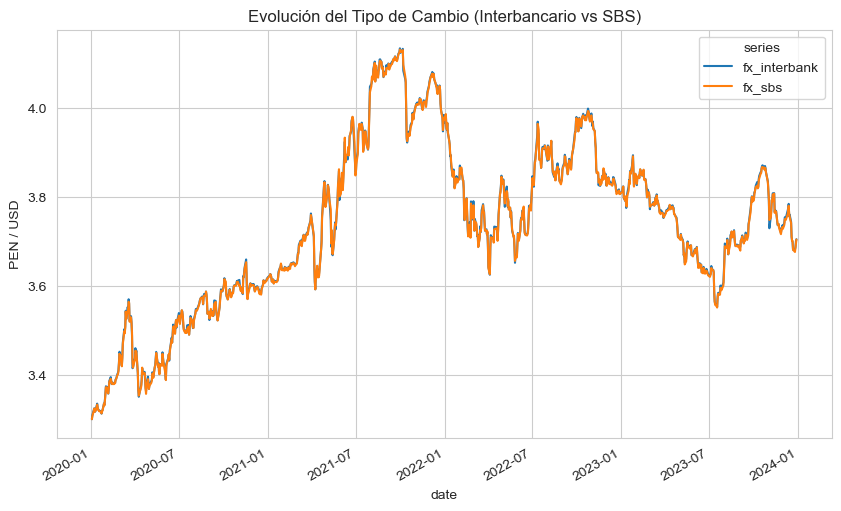

In [7]:
# Definimos las columnas a graficar
cols_fx = ['fx_interbank', 'fx_sbs']

# Graficamos usando el método plot de Pandas
df_bcrp[cols_fx].plot(figsize=(10, 6))

# Añadimos título y etiquetas en los ejes
plt.title('Evolución del Tipo de Cambio (Interbancario vs SBS)')
plt.ylabel('PEN / USD')
plt.show()

In [ ]:
# Comentario
# Ambas series se mueven casi idénticamente, mostrando que el mercado interbancario y el oficial están altamente correlacionados.

7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


In [8]:
# Usamos una función lambda para verificar si el retorno es > 0 y calculamos el promedio
pos_share = returns.apply(lambda x: (x > 0).mean())
print("Proporción de días positivos por ticker:")
print(pos_share)

Proporción de días positivos por ticker:
Ticker
GLD    0.527363
SPY    0.537313
TLT    0.487562
dtype: float64


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


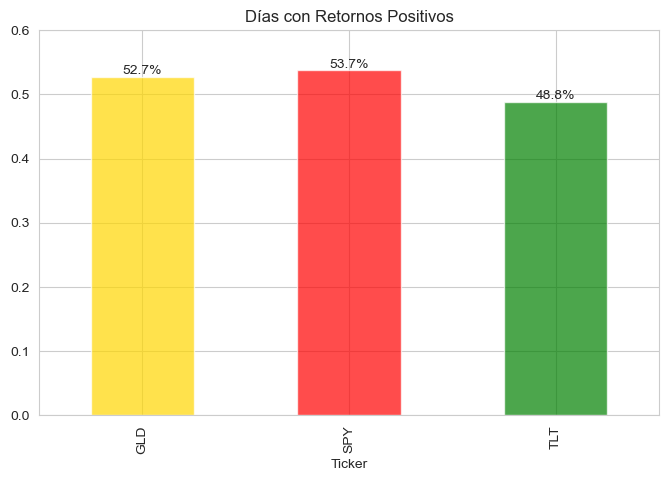

In [9]:
# Creamos el gráfico de barras
ax = pos_share.plot(kind='bar', figsize=(8, 5), color=['gold', 'red', 'green'], alpha=0.7)
plt.title('Días con Retornos Positivos')
for i, v in enumerate(pos_share):
    # annotate(texto, (x, y))
    ax.annotate(f'{v:.1%}', (i, v), ha='center', va='bottom')
plt.ylim(0, 0.6)
plt.show()

9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


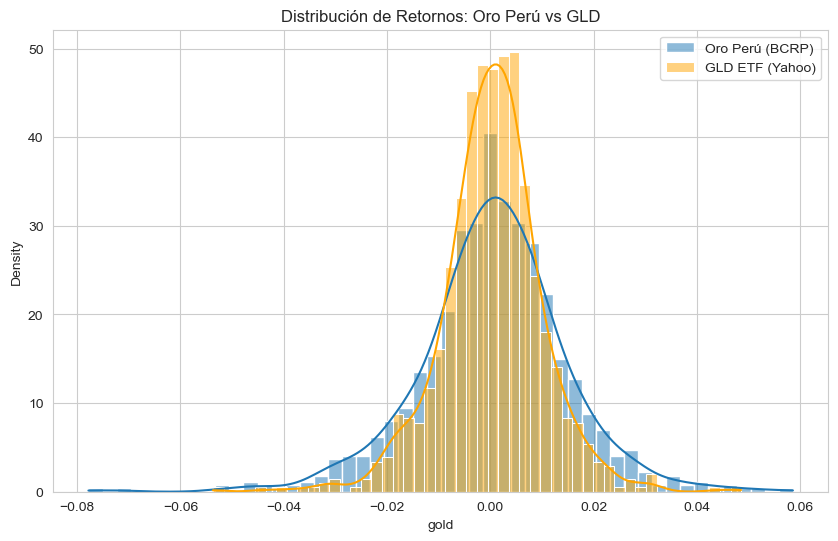

In [10]:
# Calculamos los retornos del oro peruano y de US, y se comparan en un histograma
ret_gold_pe = df_bcrp['gold'].pct_change().dropna()
ret_gld_us = returns['GLD']

plt.figure(figsize=(10, 6))
sns.histplot(ret_gold_pe, bins=50, kde=True, stat="density", label='Oro Perú (BCRP)', alpha=0.5)
sns.histplot(ret_gld_us, bins=50, kde=True, stat="density", label='GLD ETF (Yahoo)', alpha=0.5, color='orange')

plt.title('Distribución de Retornos: Oro Perú vs GLD')
plt.legend()
plt.show()

10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


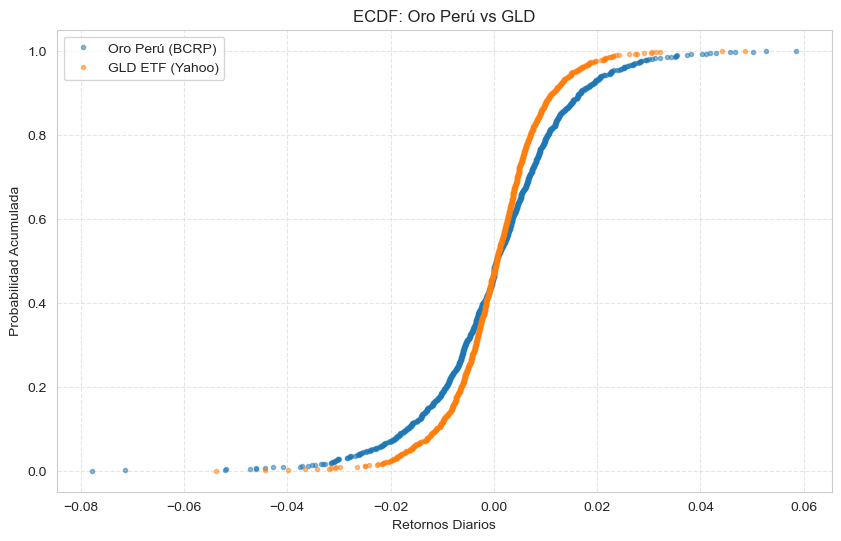

In [11]:
def plot_ecdf(data, label):
    """Genera los datos x e y para el ECDF"""
    # Ordenamos los datos de menor a mayor
    x = np.sort(data)
    # Eje y: puntos espaciados uniformemente de 1/n a 1
    y = np.arange(1, len(x) + 1) / len(x)
    plt.plot(x, y, marker='.', linestyle='none', label=label, alpha=0.5)

plt.figure(figsize=(10, 6))
# Validamos que las variables existan
if 'ret_gold_pe' not in locals():
    ret_gold_pe = df_bcrp['gold'].pct_change().dropna()
    ret_gld_us = returns['GLD']

# Graficamos el ECDF para ambas series
plot_ecdf(ret_gold_pe, 'Oro Perú (BCRP)')
plot_ecdf(ret_gld_us, 'GLD ETF (Yahoo)')

plt.title('ECDF: Oro Perú vs GLD')
plt.xlabel('Retornos Diarios')
plt.ylabel('Probabilidad Acumulada')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Comentario: 
# A diferencia del histograma, que agrupa los datos en bins y pierde detalle, la ECDF muestra cada punto de datos individualmente.
# Mientras el histograma muestra dónde se concentran los datos, la ECDF nos permite leer directamente percentiles y probabilidades 
# acumuladas, como la probabilidad acumulada de obtener un retorno menor o igual a un valor específico, algo que no es evidente 
# visualmente en el histograma.

11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


16. Standardize a variable (z-score) and plot **before vs after**.  


17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


18. Save one figure into `/figures` using `savefig` and verify the file exists.  


19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.
